# Extraction of Numbeo Data

In [ ]:
import csv,fnmatch,os,re,pickle
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
from sklearn.cross_validation import StratifiedKFold,cross_val_score
from sklearn.linear_model import SGDClassifier
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from time import time
from numbeo_data_acquisition import *
from feature_engineering import *

### Get Numbeo : loading serialized files or downloading data according to the location or the region / country from numbeo API

In [ ]:
data_folder = '/home/thebatou/Documents/Uni_Potsdam/data_analysis_bitbond/data/'
file_name = 'project_data_train_v2.csv'
file_location = os.path.join(data_folder, file_name)

print 'Trying to load bitbond data ...'
bitbond_data = pd.read_csv(file_location, index_col=0)
bitbond_data.set_value([835, 1232, 1839, 1993], 'region', 'NA')
bitbond_data.set_value([1364, 1366, 1374, 1425, 1459, 1580, 1753], 'currency', 'USD')
bitbond_data.set_value([1362, 1368], 'currency', 'HUF')
bitbond_data.set_value([1360, 1416, 1525, 1921], 'currency', 'IDR')
bitbond_data.set_value([1384, 1428, 1463, 1553, 1574, 1628, 1808], 'currency', 'INR')
bitbond_data.set_value([1369, 1435, 1693], 'currency', 'KES')
print 'Done loading bitbond data! {} data were loaded.'.format(bitbond_data.shape[0])

try:
    print ("Trying to load numbeo data about region ...")
    file_location1 = os.path.join(data_folder, 'numbeo_region_prices.csv')
    region_prices_numbeo = pd.read_csv(file_location1, index_col=0)
    region_prices_numbeo.set_value([50], 'region', 'NA')
    print "Done loading region numbeo data! {} data were loaded.".format(region_prices_numbeo.shape[0])    

    print ("Trying to load numbeo data about country ...")
    file_location2 = os.path.join(data_folder, 'numbeo_country_prices.csv')
    country_prices_numbeo = pd.read_csv(file_location2, index_col=0)
    print "Done loading country numbeo data! {} data were loaded.".format(country_prices_numbeo.shape[0])
    
    print ("Trying to load numbeo data about city ...")
    file_location3 = os.path.join(data_folder, 'numbeo_city_prices.csv')
    city_prices_numbeo = pd.read_csv(file_location3, index_col=0)
    print "Done loading city numbeo data! {} data were loaded.".format(city_prices_numbeo.shape[0])
    
    
except IOError as e:
    print "I/O error: {0}".format(e)
    print "Downloading data from numbeo website ..."
    quadruple_id_lat_long_region = bitbond_data.groupby(by=('loan_identifier','address_lat','address_lng','region')).indices.keys()
    (all_city_prices_requests, all_country_prices_requests, missing_prices_location) =  get_numbeo_data_according_to_location(quadruple_id_lat_long_region)
    print 'Missing value : {}'.format(len(missing_prices_location) != 0)
    
    city_prices_numbeo = pd.DataFrame(all_city_prices_requests)
    city_prices_numbeo['prices'] = average_salary_extraction(city_prices_numbeo['prices'])
    city_prices_numbeo.to_csv(path_or_buf=file_location3, encoding='utf-8')
    
    country_prices_numbeo = pd.DataFrame(all_country_prices_requests)
    country_prices_numbeo['prices'] = average_salary_extraction(country_prices_numbeo['prices'])
    country_prices_numbeo.to_csv(path_or_buf=file_location2, encoding='utf-8')
    
    regions = np.unique(bitbond_data.region)
    (all_region_prices_requests, missing_prices_regions) = get_numbeo_data_according_to_region(regions)
    print 'Missing value : {}'.format(len(missing_prices_regions) != 0)

    region_prices_numbeo = pd.DataFrame(all_region_prices_requests)
    region_prices_numbeo['prices'] = average_salary_extraction(region_prices_numbeo['prices'])
    region_prices_numbeo.to_csv(path_or_buf=file_location1, encoding='utf-8')

In [ ]:
print 'Bitbond data shape : {}'.format(bitbond_data.shape)
print 'City numbeo data has shape : {}'.format(city_prices_numbeo.shape)
print 'Country numbeo data has shape : {}'.format(country_prices_numbeo.shape)
print '\nFirst element of city numbeo data :'
print city_prices_numbeo.ix[0]
print '\nFirst element of country numbeo data :'
print country_prices_numbeo.ix[2]

### Cleaning bitbond data + Droping some useless data collected from Numbeo

In [ ]:
def drop_useless_column(dataframe, columns):
    for column in columns:
        dataframe.drop(column,axis=1,inplace=True)
    return dataframe

In [ ]:
def rename_column(dataframe, old_name, new_name):
    return dataframe.rename(columns={old_name:new_name})

In [ ]:
bitbond_data = bitbond_data.replace(to_replace=np.nan, value=-1)
    
columns = ['currency', 'contributors', 'monthLastUpdate', 'yearLastUpdate']

city_prices_numbeo = rename_column(drop_useless_column(city_prices_numbeo, columns),
                                   'name', 'location')
country_prices_numbeo = rename_column(drop_useless_column(country_prices_numbeo, columns),
                                      'name', 'location')
region_prices_numbeo = rename_column(drop_useless_column(region_prices_numbeo, columns),
                                     'name', 'location')

In [ ]:
print "Nombre de pair (lat, lon) unique : {}".format(len(bitbond_data.groupby(by=('address_lat','address_lng')).indices.keys()))
print "Nombre d'emprunteur : {}".format(len(np.unique(bitbond_data['borrower_identifier'])))

l1 = bitbond_data.groupby(by=('address_lat','address_lng','borrower_identifier')).indices.keys()
l2 = [(e[0],e[1]) for e in l1]
borrowers_without_address = [e[2] for e in l1 if l2.count((e[0],e[1])) > 1]
# We substract 1 because of the pair (-1,-1) in the unique addresses (pair)
print "Nombre d'emprunteur sans adresses : {}".format(len(borrowers_without_address))

#bitbond_data.loc[bitbond_data['borrower_identifier'].isin(borrowers_without_address)]

### Merging the bitbond data with the numbeo data to make one unique dataset

In [ ]:
#region_prices_numbeo[~region_prices_numbeo['region'].isin(np.unique(region_prices_numbeo['region'])[1:])]

In [ ]:
print np.unique(bitbond_data.region)
print np.unique(region_prices_numbeo.region)

In [ ]:
bitbond_numbeo_data = pd.merge(bitbond_data, region_prices_numbeo, on=['region'], how='left')
#bitbond_numbeo_data_2 = pd.merge(bitbond_numbeo_data, country_prices_numbeo, on=['loan_identifier','region','prices', 'location'], how='left')
#data = pd.merge(bitbond_numbeo_data_2, city_prices_numbeo, on=['loan_identifier','address_lat', 'address_lng', 'prices', 'location'], how='left')
data.to_csv(path_or_buf=os.path.join(data_folder,'data_num_bit.csv'), encoding='utf-8')

# Classification task

In [1]:
import csv,fnmatch,os,re,pickle
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
from sklearn.cross_validation import StratifiedKFold, cross_val_score, LabelKFold
from sklearn.linear_model import SGDClassifier, LogisticRegression
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from time import time
from numbeo_data_acquisition import *
from feature_engineering import *
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

In [2]:
file_loc = '/home/thebatou/Documents/Uni_Potsdam/data_analysis_bitbond/data/data_num_bit.csv'
print ("Trying to load the data ...")
data = pd.read_csv(file_loc, index_col=0)
print "Done loading the data! {} data were loaded.".format(data.shape)    
data = data.set_value([835, 1232, 1839, 1993], 'region', 'NA')
data['salary'] = data['net_income_cents'] / data['prices']

Trying to load the data ...
Done loading the data! (2177, 30) data were loaded.


In [3]:
from datetime import datetime
from pandas import to_datetime
from datetime import timedelta

# Extracting publication date
published_date = data['published_at']
published_date = published_date.str.rsplit(' ', expand=True, n=1)
published_date = published_date.drop(1, axis=1)

published_date = to_datetime(published_date[0], format='%Y-%m-%d %H:%M:%S')
first_date = published_date.first.im_self[0]

data['time_since_published'] = (published_date - first_date).dt.days

# Exctracting funding date
#funded_date = data['funded_at']
#funded_date = funded_date.str.rsplit(' ', expand=True, n=1)
#funded_date = funded_date.drop(1, axis=1)
#funded_date[funded_date[0]=='-1'] = pd.Timestamp.max.strftime('%Y-%m-%d %H:%M:%S')
#funded_date = to_datetime(funded_date[0], format='%Y-%m-%d %H:%M:%S')
#diff_date_pub_fund = funded_date - published_date
#print diff_date_pub_fund[diff_date_pub_fund>timedelta(days=90000)].shape

In [ ]:
#data[~data['location'].isin(np.unique(data['location'])[1:])]

In [ ]:
print 'Nominal interest rate : {}'.format(np.unique(data.nominal_interest_rate))
print 'Term : {}'.format(np.unique(data.term))
print 'Purpose : {}'.format(np.unique(data.purpose))
print 'Borrower rating : {}'.format(np.unique(data.borrower_rating))
print 'Employment : {}'.format(np.unique(data.employment))
print 'Region : {}'.format(np.unique(data.region))
print 'Prices : {}'.format(np.unique(data.prices))
print 'Facebook : {}'.format(np.unique(data.facebook))
print 'Ebay : {}'.format(np.unique(data.ebay))
print 'Status : {}'.format(np.unique(data.status))
print 'Fraudulent : {}'.format(np.unique(data.fraudulent))
print 'Currency : {}'.format(np.unique(data.currency))
print 'Rates count : {}'.format(np.unique(data.rates_count))
print 'Rates paid : {}'.format(np.unique(data.rates_paid))
print 'Base currency : {}'.format(np.unique(data.base_currency))
print 'Location : {}'.format(np.unique(data.location))

### Transformation of the data : building the features

In [4]:
print "Nombre d'emprunteur unique : {}".format(np.unique(data['borrower_identifier']).shape[0])

Nombre d'emprunteur unique : 521


In [5]:
def drop_useless_column(dataframe, columns):
    for column in columns:
        dataframe = dataframe.drop(column,axis=1)
    return dataframe

In [6]:
classif_data = data.loc[data['status'].isin(['defaulted', 'fully_paid', 'late_90',
                                             'charged_off'])]
classif_data = classif_data.copy().reset_index()

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
borrowers = le.fit_transform(classif_data['borrower_identifier'])
borrowers = pd.Series(borrowers)

In [8]:
y = classif_data['status'] == 'fully_paid'
y = y.as_matrix()
classif_data.drop('status',axis=1,inplace=True)

In [9]:
columns_to_drop = classif_data.columns.tolist()
columns_to_keep = ['term', 'linkedin', 'project_description', 'facebook', 'twitter', 'paypal',
                   'ebay', 'time_since_published']#, 'borrower_rating', 'nominal_interest_rate']
[columns_to_drop.remove(feat) for feat in columns_to_keep if feat in columns_to_drop]
classif_data = drop_useless_column(classif_data, columns_to_drop)

In [10]:
#classif_data['diff_salary_amount_requested'] = classif_data.salary - classif_data.amount_requested
#classif_data = drop_useless_column(classif_data, ['amount_requested', 'salary'])
#[columns_to_keep.remove(feat) for feat in ['amount_requested', 'salary']]

In [11]:
def preprocessing_mean_std(serie):
    return pd.DataFrame(preprocessing.scale(serie))

In [12]:
numerical_feat = [num_feat for num_feat in ['address_lat', 'address_lng', 'net_income_cents',
                                            'prices', 'salary', 'amount_requested',
                                            'diff_salary_amount_requested',
                                            'nominal_interest_rate']
                  if num_feat in columns_to_keep]

for feat in numerical_feat:
    feat_name = 'avg_'+feat
    classif_data[feat_name] = pd.DataFrame(preprocessing_mean_std(classif_data[feat]))

[columns_to_keep.remove(feat) for feat in numerical_feat if feat in columns_to_keep]

classif_data = drop_useless_column(classif_data, numerical_feat)

In [13]:
print numerical_feat
print categorical_feature

[]
['borrower_identifier', 'term', 'purpose', 'borrower_rating', 'employment', 'region', 'facebook', 'twitter', 'paypal', 'ebay', 'linkedin', 'currency', 'base_currency', 'location']


In [14]:
print 'Shape of the data : {}'.format(classif_data.shape)

Shape of the data : (608, 8)


In [15]:
from pytextprocess import Preprocesser

try:
    print ("Trying to load project description preprocessed ...")
    file_loc = os.path.join('../data/', 'project_descrip.pickle')
    with open(file_loc, 'rb') as f:
        preprocessed_proj = pickle.load(f)
    f.close()
    print "Done loading project description!"

except IOError as e:
    print "I/O error: {0}".format(e)
    print "Preprocessing the project description ..."
    preprocesser = Preprocesser(tagger_backup='/home/thebatou/Documents/Uni_Potsdam/Machine_Learning/Project/backup/tagger.pickle')
    project_describ = classif_data.project_description.to_dict().values()
    proj_desc = []
    for describ in project_describ:
        proj_desc.append(describ.decode('utf8'))
    preprocessed_proj = preprocesser.preprocess(proj_desc)
    with open(file_loc, 'wb') as f:
        pickle.dump(preprocessed_proj, f)
    f.close()

Trying to load project description preprocessed ...
Done loading project description!


In [16]:
classif_data['project_description'] = pd.Series(preprocessed_proj)

In [17]:
categorical_feature = [categ_feat for categ_feat in
                       ['term', 'purpose', 'employment', 'region', 'facebook', 'twitter',
                       'paypal', 'ebay', 'linkedin', 'currency', 'borrower_rating']
                       if categ_feat in columns_to_keep]

other_feature = [column for column in classif_data.columns.tolist() 
                 if column not in categorical_feature]

_, binarized_feat = build_categorical_feature(classif_data, categorical_feature,
                                              binary_encoding=True)
final_bin_data, latent_model = text_transformation(binarized_feat, y)

done in 2.427s.


In [18]:
X = final_bin_data.as_matrix()
#X = data_ready.as_matrix()
print 'Shape of X_bin : {}'.format(X.shape)
print 'Shape of y : {}'.format(y.shape)

Shape of X_bin : (608, 35)
Shape of y : (608,)


In [ ]:
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding
from sklearn.decomposition import KernelPCA, TruncatedSVD, PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
kernel_pca = KernelPCA(n_components=2, kernel='rbf')#, kernel='sigmoid')#, kernel='cosine')
pca = PCA(n_components=2)
svd = TruncatedSVD(n_components=2)

#tsne = TSNE(n_components=2)
#mds = MDS(n_components=2)

X_lda = lda.fit(X, y).transform(X)
X_kernel_pca = kernel_pca.fit(X, y).transform(X)
X_pca = pca.fit(X, y).transform(X)
X_svd = svd.fit(X, y).transform(X)

#X_tsne = tsne.fit_transform(X, y)
#X_mds = mds.fit_transform(X, y)

# Percentage of variance explained for each components
print 'PCA explained variance (first two components): {} {}'.format(np.around(pca.explained_variance_ratio_*100, decimals=1),
                                                                      np.sum(np.around(pca.explained_variance_ratio_*100, decimals=1)))

print 'SVD explained variance (first two components): {} {}'.format(np.around(svd.explained_variance_ratio_*100, decimals=1),
                                                                      np.sum(np.around(svd.explained_variance_ratio_*100, decimals=1)))

plt.figure(figsize=(20, 10))
plt.scatter(X_lda[:,0], X_lda[:,1], c=y, s=100)
plt.legend()
plt.title('LDA of dataset')

plt.figure(figsize=(20, 10))
plt.scatter(X_kernel_pca[:,0], X_kernel_pca[:,1], c=y, s=100)
plt.legend()
plt.title('Kernel PCA of dataset')

plt.figure(figsize=(20, 10))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=100)
plt.legend()
plt.title('PCA of dataset')

plt.figure(figsize=(20, 10))
plt.scatter(X_svd[:,0], X_svd[:,1], c=y, s=100)
plt.legend()
plt.title('SVD of dataset')

#plt.figure(figsize=(20, 10))
#plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, s=100)
#plt.legend()
#plt.title('TSNE of dataset')

#plt.figure(figsize=(20, 10))
#plt.scatter(X_mds[:,0], X_mds[:,1], c=y, s=100)
#plt.legend()
#plt.title('MDS of dataset')

plt.show()

Shape of X_train : (486, 35)
Shape of X_test : (122, 35)
Classification report for classifier (LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2',
          random_state=<mtrand.RandomState object at 0x7fc94c1c5cd0>,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), 'Logistic Regression'):
             precision    recall  f1-score   support

      False       0.77      0.46      0.57        59
       True       0.63      0.87      0.73        63

avg / total       0.70      0.67      0.66       122


Confusion matrix:
[[27 32]
 [ 8 55]]
Shape of X_train : (486, 35)
Shape of X_test : (122, 35)
Classification report for classifier (LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2',
          random_state=<mtrand.RandomStat

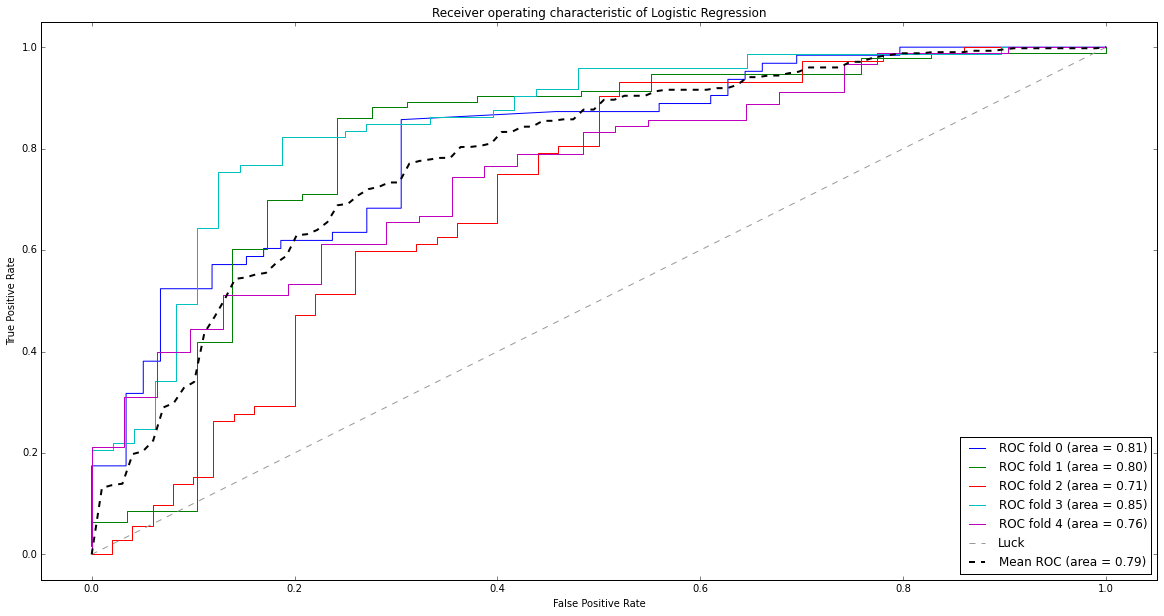

Shape of X_train : (486, 35)
Shape of X_test : (122, 35)
Classification report for classifier (SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'SVC with linear kernel'):
             precision    recall  f1-score   support

      False       0.77      0.39      0.52        59
       True       0.61      0.89      0.72        63

avg / total       0.69      0.65      0.62       122


Confusion matrix:
[[23 36]
 [ 7 56]]
Shape of X_train : (486, 35)
Shape of X_test : (122, 35)
Classification report for classifier (SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'SVC with linear kernel'):
             precision    recall  f1-score   supp

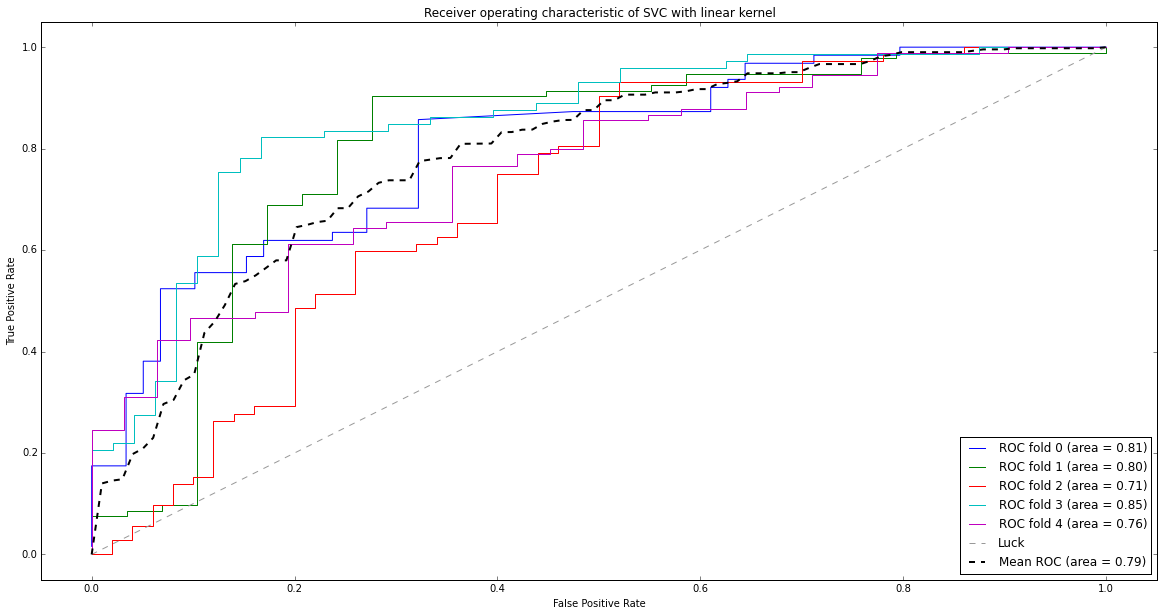

Shape of X_train : (486, 35)
Shape of X_test : (122, 35)
Classification report for classifier (LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), 'LinearSVC'):
             precision    recall  f1-score   support

      False       0.76      0.44      0.56        59
       True       0.62      0.87      0.73        63

avg / total       0.69      0.66      0.65       122


Confusion matrix:
[[26 33]
 [ 8 55]]
Shape of X_train : (486, 35)
Shape of X_test : (122, 35)
Classification report for classifier (LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), 'LinearSVC'):
             precision    recall  f1-score   support

      False       0.50      0.76      0.6

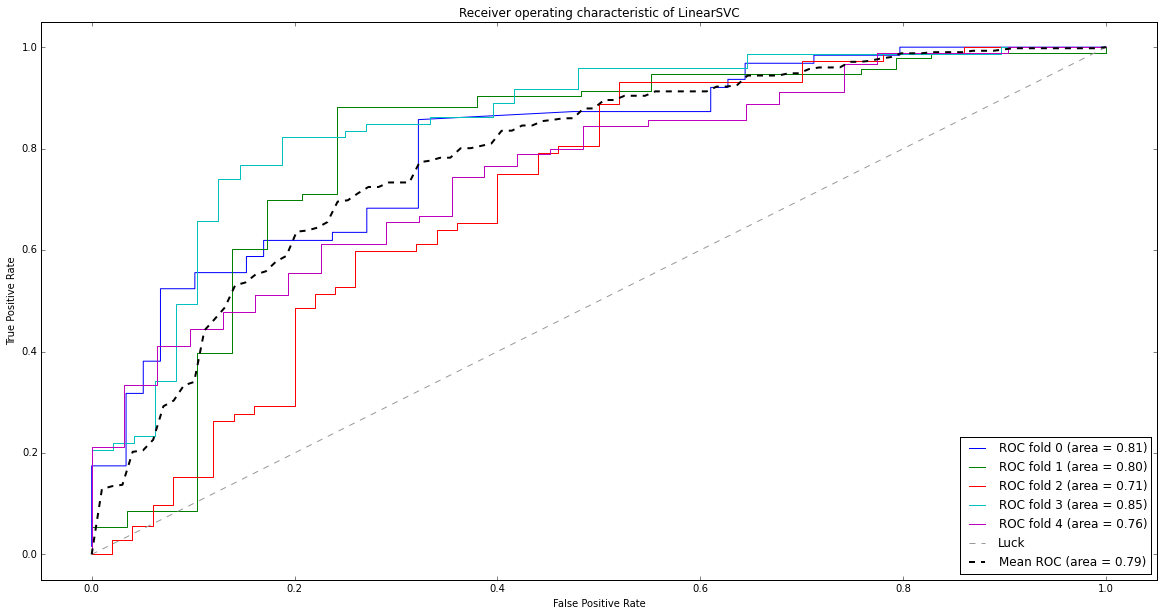

In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_validation import LeaveOneLabelOut
#from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
#from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss, hinge_loss, mean_squared_error

random_state = np.random.RandomState(0)

lda = LinearDiscriminantAnalysis(n_components=2)

clfs = [(LogisticRegression(random_state=random_state),'Logistic Regression'),
        (SVC(kernel='linear' ,probability=True), 'SVC with linear kernel' ),
        (LinearSVC(dual=False), 'LinearSVC')]

lkf = LabelKFold(borrowers, n_folds=5)

list_log_loss = []
list_hinge_loss = []

for clf in clfs :
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    res_log_loss = []
    res_hinge_loss = []
    plt.figure(figsize=(20,10))

    for i, (train, test) in enumerate(lkf):
        X_train = X[train]
        X_test = X[test]
        print 'Shape of X_train : {}'.format(X_train.shape)
        print 'Shape of X_test : {}'.format(X_test.shape)
    
        lda = lda.fit(X_train, y[train])
        X_lda = lda.transform(X_train)
        X_tr = X_lda
        
        #lda = lda.fit(X_train[:, 20:], y[train])
        #X_lda = lda.transform(X_train[:, 20:])

        #X_tr = np.concatenate((X_lda, X_train[:,:20]), axis=1)

        clf[0].fit(X_tr, y[train])

        X_test_lda = lda.transform(X_test)
        X_te = X_test_lda
        
        #X_test_lda = lda.transform(X_test[:,20:])
        #X_te = np.concatenate((X_test_lda, X_test[:,:20]), axis=1)
        
        if clf is not clfs[2]:
            res_log_loss.append(log_loss(y[test], clf[0].predict_proba(X_te)))
        res_hinge_loss.append(hinge_loss(y[test], clf[0].decision_function(X_te)))
        # Compute ROC curve and area the curve
        probas = clf[0].decision_function(X_te)#[:,1]
        fpr, tpr, thresholds = roc_curve(y[test], probas)

        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        # Now predict the value of the digit on the second half:
        expected = y[test]
        predicted = clf[0].predict(X_te)

        print("Classification report for classifier %s:\n%s\n"
              % (clf, metrics.classification_report(expected, predicted)))
        print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))
        #print("Precision : {}").format(metrics.precision_score(expected, predicted))
        #print("Recall : {}").format(metrics.recall_score(expected, predicted))
    list_log_loss.append(res_log_loss)
    list_hinge_loss.append(res_hinge_loss)
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(lkf)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of %s' % clf[1])
    plt.legend(loc="lower right")
    plt.show()

Shape of X_train : (396, 35)
Shape of X_test : (99, 35)
Classification report for classifier LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False):
             precision    recall  f1-score   support

      False       0.86      0.68      0.76        47
       True       0.76      0.90      0.82        52

avg / total       0.81      0.80      0.79        99


Confusion matrix:
[[32 15]
 [ 5 47]]
Shape of X_train : (396, 35)
Shape of X_test : (99, 35)
Classification report for classifier LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False):
             precision    recall 

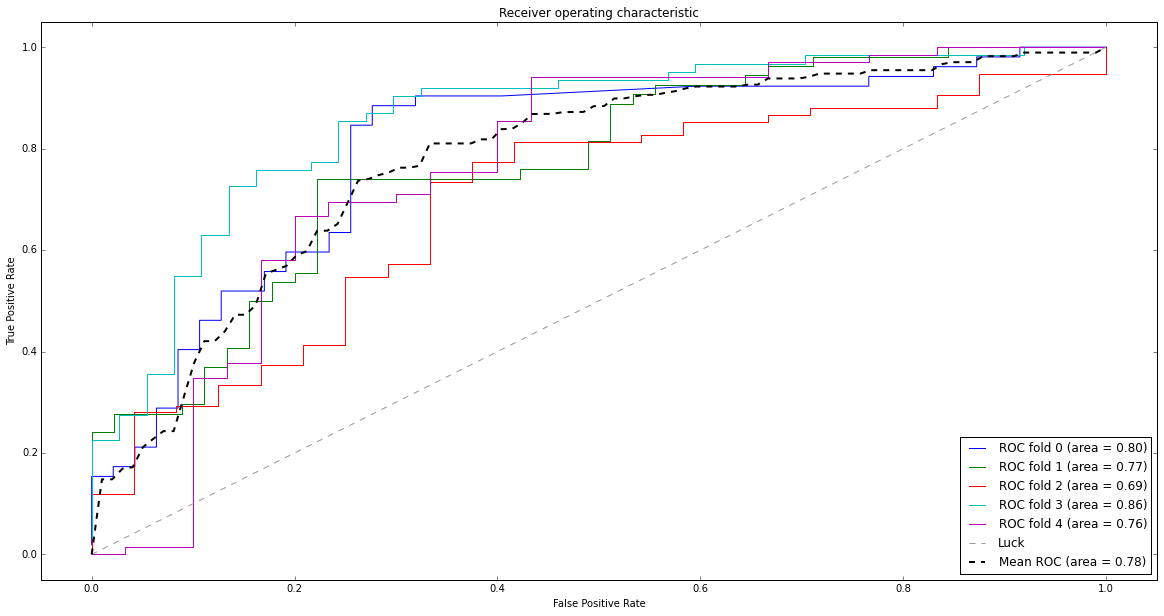

Classification report for classifier LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False):
             precision    recall  f1-score   support

      False       0.52      0.41      0.46        34
       True       0.77      0.84      0.80        79

avg / total       0.69      0.71      0.70       113


Confusion matrix:
[[14 20]
 [13 66]]


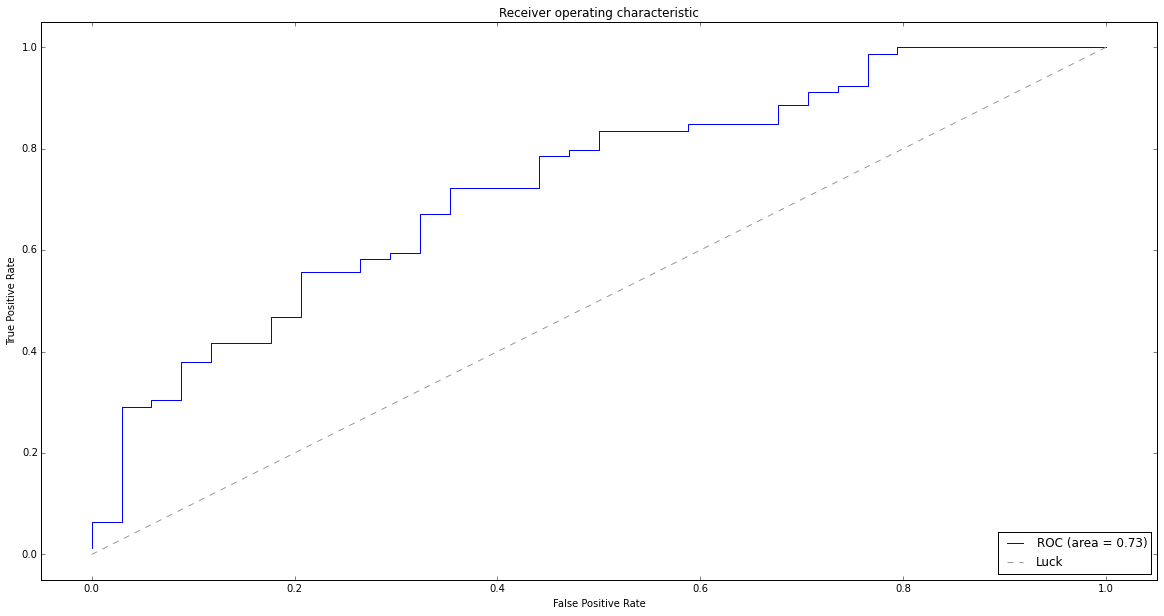

Shape of X_train : (373, 35)
Shape of X_test : (94, 35)
Classification report for classifier LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False):
             precision    recall  f1-score   support

      False       0.75      0.39      0.51        46
       True       0.60      0.88      0.71        48

avg / total       0.67      0.64      0.62        94


Confusion matrix:
[[18 28]
 [ 6 42]]
Shape of X_train : (373, 35)
Shape of X_test : (94, 35)
Classification report for classifier LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False):
             precision    recall 

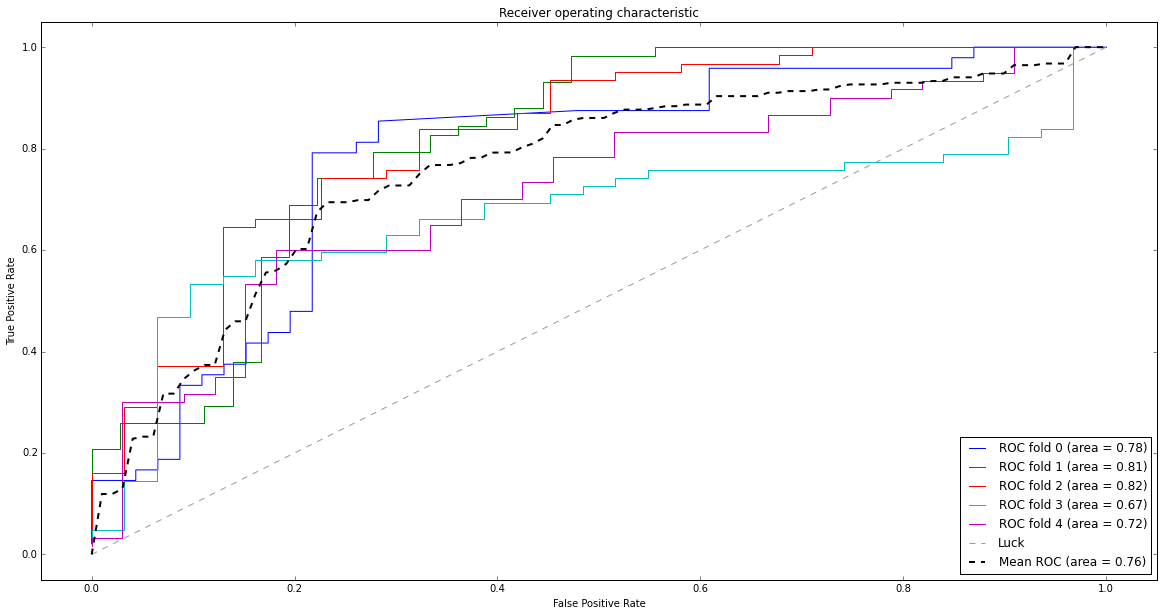

Classification report for classifier LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False):
             precision    recall  f1-score   support

      False       0.66      0.57      0.61        40
       True       0.84      0.88      0.86       101

avg / total       0.79      0.79      0.79       141


Confusion matrix:
[[23 17]
 [12 89]]


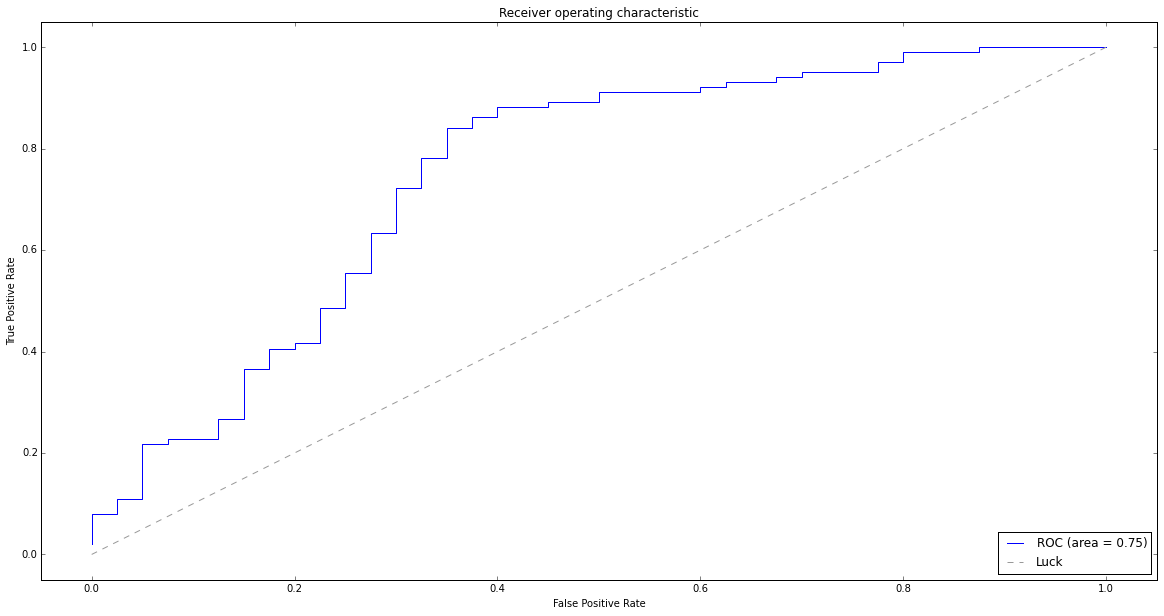

Shape of X_train : (393, 35)
Shape of X_test : (99, 35)
Classification report for classifier LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False):
             precision    recall  f1-score   support

      False       0.70      0.77      0.73        39
       True       0.84      0.78      0.81        60

avg / total       0.78      0.78      0.78        99


Confusion matrix:
[[30  9]
 [13 47]]
Shape of X_train : (393, 35)
Shape of X_test : (99, 35)
Classification report for classifier LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False):
             precision    recall 

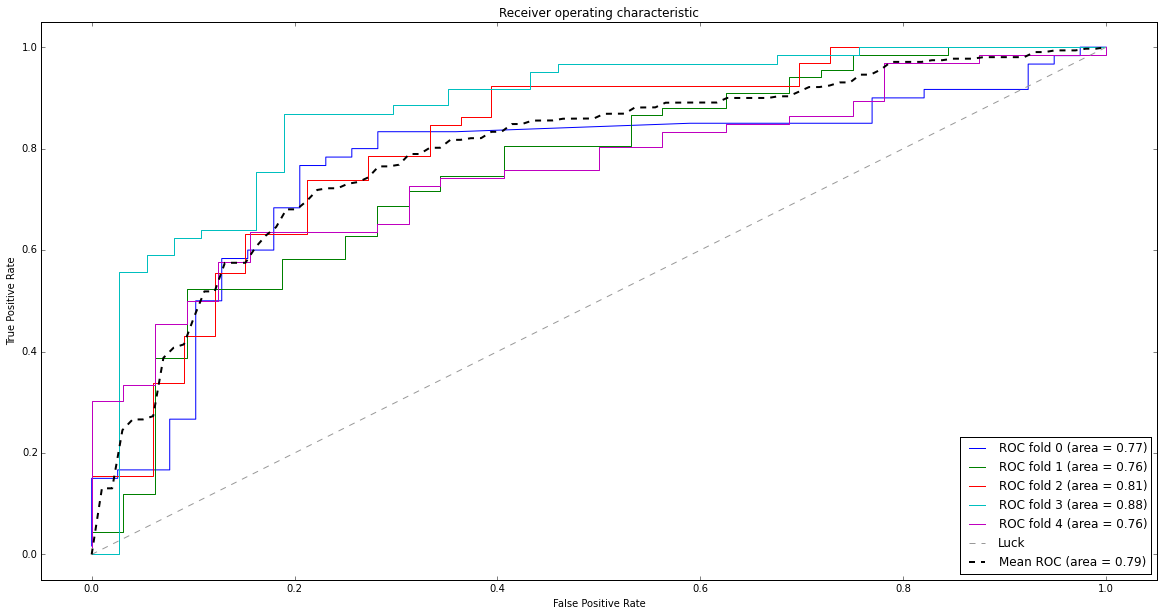

Classification report for classifier LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False):
             precision    recall  f1-score   support

      False       0.72      0.52      0.61        44
       True       0.75      0.88      0.81        72

avg / total       0.74      0.74      0.73       116


Confusion matrix:
[[23 21]
 [ 9 63]]


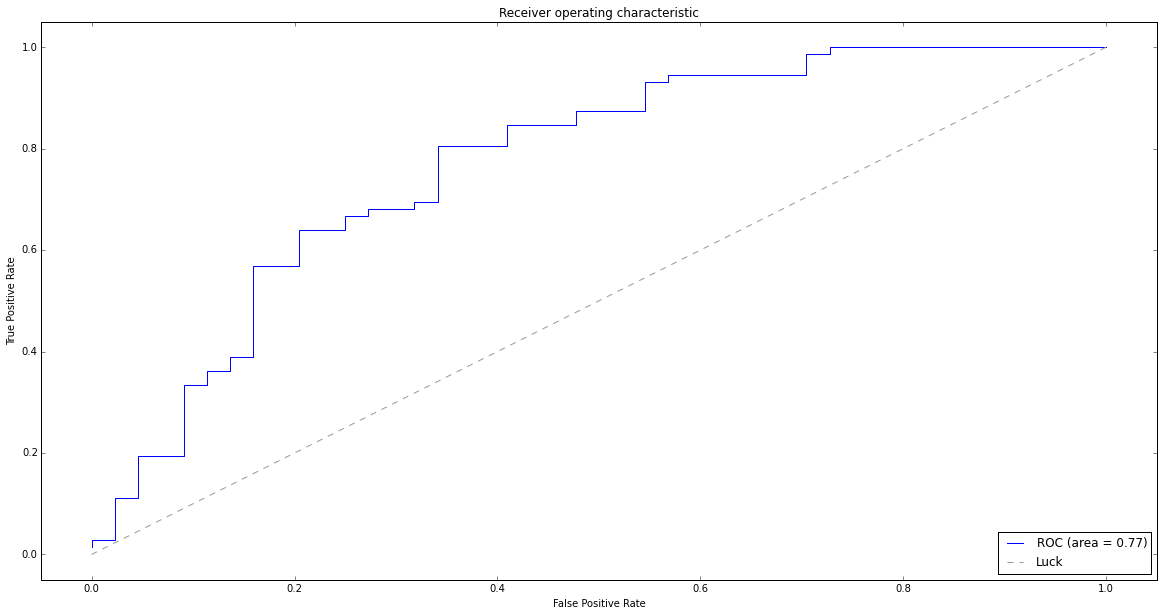

In [45]:
from sklearn.cross_validation import LabelShuffleSplit

outer_loop_cv = LabelShuffleSplit(borrowers, n_iter=3)

clfs = [LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1),
        LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1),
        LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1)]

list_log_loss = []

for hyperparam, (outer_train, outer_test) in enumerate(outer_loop_cv):
    X_outer_train = X[outer_train]
    y_outer_train = y[outer_train]
    X_outer_test = X[outer_test]
    y_outer_test = y[outer_test]
    
    lkf = LabelKFold(borrowers[outer_train], n_folds=5)
    
    clf = clfs[hyperparam]
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    res_log_loss = []
    plt.figure(figsize=(20,10))

    for i, (train, test) in enumerate(lkf):
        X_train = X_outer_train[train]
        y_train = y_outer_train[train]
        X_test = X_outer_train[test]
        y_test = y_outer_train[test]
        print 'Shape of X_train : {}'.format(X_train.shape)
        print 'Shape of X_test : {}'.format(X_test.shape)

        #lda = lda.fit(X_train, y[train])
        #X_lda = lda.transform(X_train)
        #X_tr = X_lda

        #lda = lda.fit(X_train[:, 20:], y[train])
        #X_lda = lda.transform(X_train[:, 20:])

        #X_tr = np.concatenate((X_lda, X_train[:,:20]), axis=1)

        clf.fit(X_train, y_train)
        #clf.fit(X_tr, y[train])

        #X_test_lda = lda.transform(X_test)
        #X_te = X_test_lda

        #X_test_lda = lda.transform(X_test[:,20:])
        #X_te = np.concatenate((X_test_lda, X_test[:,:20]), axis=1)

        res_log_loss.append(log_loss(y_test, clf.predict_proba(X_test)))

        # Compute ROC curve and area the curve
        probas = clf.decision_function(X_test)#[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, probas)

        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        # Now predict the value of the digit on the second half:
        expected = y_test
        predicted = clf.predict(X_test)

        print("Classification report for classifier %s:\n%s\n"
              % (clf, metrics.classification_report(expected, predicted)))
        print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))
    list_log_loss.append(res_log_loss)

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(lkf)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    plt.figure(figsize=(20,10))
    
    #--------------------------------------
    
    clf.fit(X_outer_train, y_outer_train)
    
    probas_outer = clf.predict_proba(X_outer_test)
    loss = log_loss(y_outer_test, probas_outer)
    
    fpr, tpr, thresholds = roc_curve(y_outer_test, clf.decision_function(X_outer_test))

    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % roc_auc)
    # Now predict the value of the digit on the second half:
    expected = y_outer_test
    predicted = clf.predict(X_outer_test)
    print("Classification report for classifier %s:\n%s\n"
          % (clf, metrics.classification_report(expected, predicted)))
    print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [48]:
print [np.mean(log) for log in list_log_loss]
print list_log_loss

[0.63949930540176891, 0.6035602718064752, 0.56082967666748884]
[[0.59548763428314955, 0.69011189098045633, 0.8673657209740635, 0.45545919798919193, 0.58907208278198353], [0.62820030460988374, 0.48891012066944678, 0.47290370095037654, 0.74439335935623818, 0.68339387344643088], [0.60043776545820382, 0.52595992404130643, 0.51595888269718559, 0.56740662886600945, 0.59438518227473869]]


In [ ]:
features = data.columns.tolist()
to_keep = ['status', 'address_lat', 'address_lng']
to_drop = [feature for feature in features if feature not in to_keep]

location_data = data.loc[data['status'].isin(['defaulted', 'fully_paid',
                                            'late_90', 'charged_off'])]
location_data = location_data.copy().reset_index(drop=True)
loc_data = drop_useless_column(location_data, to_drop)

y = loc_data['status'] == 'fully_paid'
y = y.as_matrix()
loc_data.drop('status',axis=1,inplace=True)
X = loc_data.as_matrix()

In [ ]:
fig = plt.figure(figsize=(20, 10))
plt.clf()
for i in range(X.shape[0]):
    plt.text(X[i, 1], X[i, 0], str(location_data.loc[i,'region']),
             fontdict={'size': 20})
    
plt.scatter(X[:, 1], X[:, 0], c=y, s=100)
plt.show()

In [ ]:
location_data = data.loc[data['status'].isin(['defaulted', 'fully_paid',
                                            'late_90', 'charged_off'])]

gb = location_data.loc[:,['region','status']].copy()
gb = gb.groupby(by=['region','status'])
aggr = gb.size()
print 'Number of default / not default : {} / {}'.format(location_data[location_data['status'] == 'fully_paid'].shape[0],
                                                         location_data[location_data['status'] != 'fully_paid'].shape[0])
pd.DataFrame(aggr)